Собственные значения в порядке убывания:
437.77467247979916
137.1045707202104
22.01353133569721
3.1072254642928634
Доля дисперсии, описываемая каждой из компонент 
[72.96244541329992, 22.85076178670175, 3.668921889282871, 0.5178709107154776]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]
Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


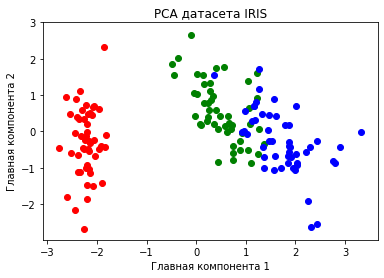

In [1]:
%run ./Lesson_8_010722.ipynb

1. Можно ли отобрать наиболее значимые признаки с помощью PCA? Ответ объясните.

*Да. Сначала PCA осуществляет стандартизацию признаков, чтобы каждый из них вносил равный вклад в анализ. Далее метод сводится к вычислению собственных векторов и собственных значений ковариационной матрицы исходных данных. Считается, что чем больше дисперсия значений рассматриваемого признака, тем более значим признак для объяснения значений целевой переменной (при условии масштабированности признакового пространства). Собственные векторы матрицы ковариации на самом деле являются направлениями осей, где наблюдается наибольшая дисперсия (большая часть информации) и которые мы называем главными компонентами. А собственные значения – это просто коэффициенты, прикреплённые к собственным векторам, которые дают величину дисперсии, переносимую в каждом основном компоненте. Ранжируя собственные векторы в порядке от наибольшего собственного значения к наименьшему, мы получаем главные компоненты (значимые признаки) в порядке их значимости.*

2. (\*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html). Применить к данным на уроке и сравнить ответы.

In [2]:
U, d, Vt = np.linalg.svd(X_, full_matrices=False)
D = np.diag(d)
V = Vt.T
assert(np.allclose(np.square(d), eig_values))

k = 2

# XX = U[:, :k] @ D[:k, :k] @ Vt[:k,:]
# print("Using all PCs, MSE = %.6G" %(np.mean((X_ - U @ D @ Vt)**2)))
# print("Using first 20 PCs, MSE = %.6G" %(np.mean((X_ - XX)**2)))

W = V[:, :k]
Zsvd = X_ @ W
print(np.allclose(Z, Zsvd))

True


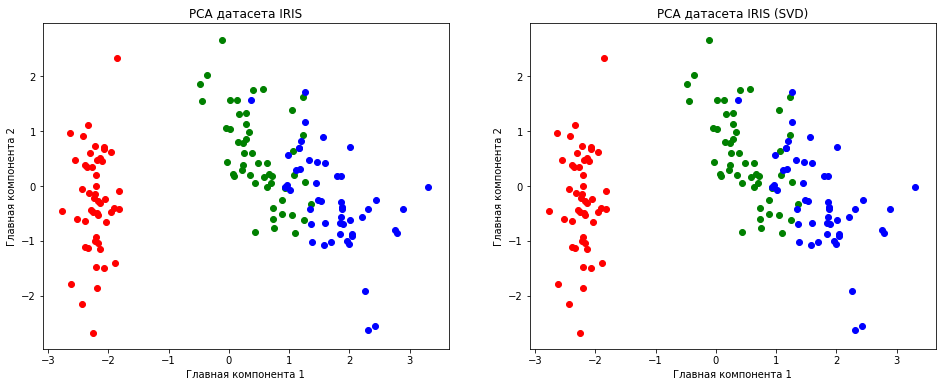

In [3]:
plt.figure(figsize=(16,6))
y = iris.target

plt.subplot(1,2,1)
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')

plt.subplot(1,2,2)
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Zsvd[y==i, 0], Zsvd[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS (SVD)')
plt.show()

*Результаты, полученные исходным PCA и PCA с использованием SVD, оказались идентичны друг другу.*

3. (\*) Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [5]:
def gini(labels):
    """критерий Джини"""
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1 # коэффициент неопределённости Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [6]:
class Node:
    """узел дерева"""
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
class Leaf:
    """лист дерева"""
    
    def __init__(self, data, labels, regression):
        self.data = data
        self.labels = labels
        self.regression = regression
        self.prediction = self.predict()
        
    def predict(self):
        if self.regression:
            prediction = np.mean(self.labels)  # среднее значение по выборке
        else:
            # подсчёт количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0 
                classes[label] += 1
            # найдём класс, количество объектов которого будет максимальным в этом листе и вернём его
            prediction = max(classes, key=classes.get)
        return prediction

In [8]:
class MyDecisionTree:
    def __init__(self, random_state=None, min_leaf=1, max_depth=10**9, max_leaf_nodes=10**9, regression=True):
        """
        конструктор дерева

        :param min_leaf: минимальное количество объектов в листе
        :param max_depth: максимальная глубина дерева
        :param max_leaf_nodes: максимальное количество листьев
        :param inf_crit_func: критерий информативности
        """
        self.root = None
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.regression = regression
        self.inf_crit_func = np.var if regression else gini  # критерий информативности
    
    def quality(self, left_labels, right_labels, current_inf_crit):
        """расчёт качества"""
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])  
        return current_inf_crit - p * self.inf_crit_func(left_labels) - (1 - p) * self.inf_crit_func(right_labels)
    
    def split(self, data, labels, index, t):
        """разбиение датасета в узле"""

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def find_best_split(self, data, labels):
        """нахождение наилучшего разбиения"""

        current_inf_crit = self.inf_crit_func(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                # пропускаем разбиения, в которых в узле остаётся менее min_leaf объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_inf_crit)

                # выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def build_tree(self, data, labels, _leaves=0, _branches=0, _depth=0):
        """
        построение дерева с помощью рекурсивной функции

        :param data: данные
        :param labels: метки
        :return: узел дерева, кол-во листьев, кол-во ветвей
        """

        quality, t, index = self.find_best_split(data, labels)

        # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if (quality == 0) or ((self.max_leaf_nodes - _leaves - _branches) < 2) or (_depth >= self.max_depth):
            _leaves += 1
            return Leaf(data, labels, regression=self.regression), _leaves, _branches

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        _branches += 1
        true_branch, _leaves, _branches = self.build_tree(true_data, true_labels, _leaves, _branches, _depth+1)
        _branches -= 1
        false_branch, _leaves, _branches = self.build_tree(false_data, false_labels, _leaves, _branches, _depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.root = Node(index, t, true_branch, false_branch)
        return self.root, _leaves, _branches
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def fit(self, X, y):
        reg_tree, *_ = self.build_tree(X, y)
        return reg_tree
    
    def predict(self, X):
        classes = []
        for obj in X:
            prediction = self.classify_object(obj, self.root)
            classes.append(prediction)
        return classes

In [9]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [10]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, y, test_size=0.25, random_state=42)

In [11]:
tree = MyDecisionTree(max_depth=3, regression=False, random_state=42)

In [12]:
tree.fit(X_train, y_train);

In [13]:
y_pred = tree.predict(X_test)

In [14]:
import sklearn.metrics as skm
skm.accuracy_score(y_test, y_pred)

0.9736842105263158

In [15]:
U, d, Vt = np.linalg.svd(X_, full_matrices=False)
V = Vt.T
k = 2
W = V[:, :k]
X_train2 = X_train @ W
X_test2 = X_test @ W

In [16]:
tree.fit(X_train2, y_train);

In [17]:
y_pred2 = tree.predict(X_test2)

In [18]:
skm.accuracy_score(y_test, y_pred2)

0.9210526315789473